In [1]:
# importo i pacchetti necessari
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker
import seaborn as sns
from scipy import stats

# random forest
from sklearn.ensemble import RandomForestClassifier

# logistic regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, recall_score, roc_auc_score

# k-NN
from sklearn import neighbors
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shahir/protein-data-set")
print("Path to dataset files:", path)

/home/lancini/proteinnet7/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/lancini/.cache/kagglehub/datasets/shahir/protein-data-set/versions/1


In [2]:
import pandas as pd
dataset_1=pd.read_csv("pdb_data_seq.csv")
dataset_2=pd.read_csv("pdb_data_no_dups.csv")

In [3]:
data_merge = dataset_1.merge(dataset_2,how='inner',on='structureId')

In [4]:
len(data_merge)

471149

In [5]:
data_merge["classification"].value_counts()

classification
RIBOSOME                    60710
HYDROLASE                   47833
TRANSFERASE                 37726
OXIDOREDUCTASE              35114
IMMUNE SYSTEM               15989
                            ...  
POTASSIUM CHANNELS              1
GALECTIN                        1
SUMO CONJUGATING ENZYME         1
OXIDOREDUCTASE/SUBSTRATE        1
cell cycle/inhibitor            1
Name: count, Length: 4989, dtype: int64

In [6]:
data_merge['classification'].value_counts().plot.pie(autopct='%1.8f%%');

Error in callback <function flush_figures at 0x7b908e2237e0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Come si può vedere il grafico è veramente molto confuso visto che ci sono numerosissime classi, alcune anche irrilevanti sul totale del dataset, per cui per rendere le cose più fattibili, creiamo un classificatore con solo le 10 classi più rappresentate


In [7]:
class_counts = data_merge["classification"].value_counts()
top_classes = class_counts.nlargest(10).index
data_merge = data_merge[data_merge["classification"].isin(top_classes)]

In [8]:
data_merge['classification'].value_counts()

classification
RIBOSOME                         60710
HYDROLASE                        47833
TRANSFERASE                      37726
OXIDOREDUCTASE                   35114
IMMUNE SYSTEM                    15989
LYASE                            11871
HYDROLASE/HYDROLASE INHIBITOR    11262
VIRUS                            10832
TRANSCRIPTION                    10564
VIRAL PROTEIN                     8875
Name: count, dtype: int64

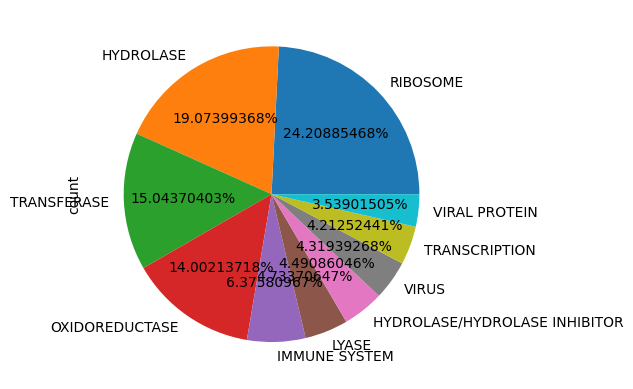

In [9]:
data_merge['classification'].value_counts().plot.pie(autopct='%1.8f%%');

è chiaro come la nostra variabile target sia "classification", per cui dobbiamo trovare delle combinazioni degli altri attributi che mi consentano di caratterizzare tale attributo
Gli attributi sono molti, per cui cerchiamo di fare prima di tutto una riduzione dimensionale.
Prima di tutto proviamo a vedere con una matrice di correlazione se si possono scartare degli attributi, che presentano alte dipendenze tra di loro.

Per prima cosa dobbiamo capire come trattare gli attributi categorici

In [10]:
data_merge.select_dtypes(include=['object', 'category']).columns

Index(['structureId', 'chainId', 'sequence', 'macromoleculeType_x',
       'classification', 'experimentalTechnique', 'macromoleculeType_y',
       'crystallizationMethod', 'pdbxDetails'],
      dtype='object')

# RIDUZIONE DIMENSIONALE

In [11]:
attributi_da_togliere=[]

In [12]:
data_merge["macromoleculeType_x"].value_counts()

macromoleculeType_x
Protein                       180125
Protein#RNA                    41426
Protein#DNA                     1589
Protein#DNA#RNA                  738
Protein#RNA#DNA/RNA Hybrid       226
RNA                               52
Protein#DNA/RNA Hybrid            16
Protein#DNA#DNA/RNA Hybrid         4
RNA#DNA/RNA Hybrid                 2
Name: count, dtype: int64

In [13]:
data_merge["macromoleculeType_y"].value_counts()

macromoleculeType_y
Protein                       180125
Protein#RNA                    41426
Protein#DNA                     1589
Protein#DNA#RNA                  738
Protein#RNA#DNA/RNA Hybrid       226
RNA                               52
Protein#DNA/RNA Hybrid            16
Protein#DNA#DNA/RNA Hybrid         4
RNA#DNA/RNA Hybrid                 2
Name: count, dtype: int64

Da qua vediamo come le due colonne macromoleculeType siano la stessa cosa, quindi procediamo togliendone una

In [14]:
data_merge.rename({'macromoleculeType_x':'macromoleculeType','residueCount_y':'residueCount'},axis=1,inplace=True)
data_merge.drop(['macromoleculeType_y','residueCount_x'],axis=1,inplace=True)

In [15]:
data_merge['macromoleculeType'] = data_merge['macromoleculeType'].str.replace('#', ' ')
data_merge['macromoleculeType'] = data_merge['macromoleculeType'].str.replace('/', ' ')

Andiamo a vedere quali sono gli attributi correlati tra loro, cioè quelli che presentano un indice di correlazione superiore a 0.9

In [16]:
# Calcola la matrice di correlazione Spearman (o Pearson)
attributi_numerici=data_merge.select_dtypes(include=['float64', 'int64'])
correlation_matrix_pearson = attributi_numerici.corr(method='pearson')
correlation_matrix_pearson = abs(correlation_matrix_pearson)

correlation_matrix_spearman = attributi_numerici.corr(method='spearman')
correlation_matrix_spearman = abs(correlation_matrix_spearman)

# attributi correlati tramite pearson
correlation_attributes_pearson=[]
attributes_name = attributi_numerici.columns

treeshold_correlation = 0.9
for i in range(len(correlation_matrix_pearson.columns)):
    for j in range(i): # la matrice è simmetrica
        if correlation_matrix_pearson.iloc[i,j] >= treeshold_correlation:
            correlation_attributes_pearson.append((attributes_name[i], attributes_name[j], correlation_matrix_pearson.iloc[i,j]))
print(correlation_attributes_pearson)


# attributi correlati tramite spearman
correlation_attributes_spearman=[]
attributes_name = attributi_numerici.columns

treeshold_correlation = 0.9
for i in range(len(correlation_matrix_spearman.columns)):
    for j in range(i): # la matrice è simmetrica
        if correlation_matrix_spearman.iloc[i,j] >= treeshold_correlation:
            correlation_attributes_spearman.append((attributes_name[i], attributes_name[j], correlation_matrix_spearman.iloc[i,j]))
print(correlation_attributes_spearman)


[('structureMolecularWeight', 'residueCount', np.float64(0.9107105993614499)), ('densityPercentSol', 'densityMatthews', np.float64(0.9159070585400809))]
[('structureMolecularWeight', 'residueCount', np.float64(0.99043735141425)), ('densityPercentSol', 'densityMatthews', np.float64(0.9877273960940885))]


Come si può vedere dal risultato, possiamo scegliere di droppare densityMatthews e residueCount

In [17]:
attributi_da_togliere.append("residueCount")
attributi_da_togliere.append("densityMatthews")

Togliamo anche l'anno di pubblicazione per ovvi motivi

In [18]:
attributi_da_togliere.append("publicationYear")

Un altro modo per togliere attributi numerici è quello di togliere quelli che hanno poca variabilità. Se ad esempio una colonna è fatta da tutti "1" mi è inutile per la predizione finale. Questa "poca variabilità" la definiamo con un rapporto tra std e media molto basso, cioè sotto il 5%

In [19]:
numerical_cols = data_merge.select_dtypes(include=[np.number])
mean = numerical_cols.mean()
std = numerical_cols.std()
cv = std / (mean.replace(0, np.nan) + 1e-8)
low_cv_cols = cv[cv < 0.05].index.tolist()
print("Colonne con coefficiente di variazione basso:", low_cv_cols)

Colonne con coefficiente di variazione basso: ['crystallizationTempK', 'publicationYear']


In [20]:
attributi_da_togliere.append("crystallizationTempK")

In [21]:
attributi_da_togliere

['residueCount', 'densityMatthews', 'publicationYear', 'crystallizationTempK']

In [22]:
data_merge=data_merge.drop(columns=attributi_da_togliere)

# RIMOZIONE DELLE ISTANZE INCOMPLETE

In [23]:
data_merge.isna().sum()

structureId                     0
chainId                         9
sequence                        1
macromoleculeType           26598
classification                  0
experimentalTechnique           0
resolution                   7866
structureMolecularWeight        0
crystallizationMethod       85719
densityPercentSol           46678
pdbxDetails                 45108
phValue                     67019
dtype: int64

In [24]:
print("istanze dataset iniziale", len(data_merge))
data_merge=data_merge.dropna()
print("istanze dataset post dropna", len(data_merge))

istanze dataset iniziale 250776
istanze dataset post dropna 135305


In [25]:
data_merge.to_csv("dataset_pronto.csv", index=False)

Come si può vedere, togliendo le righe con valori mancanti se ne va un pezzo consistente del dataset, ma rimaniamo adesso con un dataset più pulito ed utilizzabile

# MODELLI VARI DI PREDIZIONE

Per fare questa classificazione usiamo una rete neurale classica (MLP) in quanto ci aiuta l'utilizzo dell'embedding per gestire gli attributi categorici

In [26]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [27]:
CSV_PATH = "dataset_pronto.csv"
BATCH_SIZE = 512
EPOCHS = 20
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [28]:
df = pd.read_csv(CSV_PATH)

In [45]:
df.dtypes

sequence                     object
macromoleculeType             int64
classification               object
experimentalTechnique         int64
resolution                  float64
structureMolecularWeight    float64
crystallizationMethod         int64
densityPercentSol           float64
phValue                     float64
encoded_sequence             object
target                        int64
dtype: object

In [29]:
# Togliamo anche altre colonne troppo complicate o non utilizzabili
df = df.drop(columns=["structureId", "pdbxDetails", "chainId"])

In [30]:
# encoder per attributi categorici
categorical_cols = ['macromoleculeType', 'experimentalTechnique', 'crystallizationMethod']
categorical_encoders = {}
categorical_dims = []

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    categorical_encoders[col] = le
    categorical_dims.append(len(le.classes_))
    
print(df[categorical_cols].dtypes)
print(df[categorical_cols].values)

macromoleculeType        int64
experimentalTechnique    int64
crystallizationMethod    int64
dtype: object
[[  0   6 194]
 [  0   6 194]
 [  0   6 135]
 ...
 [  0   6 141]
 [  0   6 148]
 [  0   6 148]]


In [31]:
# scaler per attributi numerici
numeric_cols = ['resolution', 'structureMolecularWeight', 'densityPercentSol', 'phValue']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
print(df[numeric_cols].dtypes)
print(df[numeric_cols].head())
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

resolution                  float64
structureMolecularWeight    float64
densityPercentSol           float64
phValue                     float64
dtype: object
   resolution  structureMolecularWeight  densityPercentSol   phValue
0   -0.729051                 -0.471810          -0.247236 -0.242378
1   -0.729051                 -0.471810          -0.247236 -0.242378
2   -0.865859                 -0.484314          -1.579998 -0.102077
3   -0.428074                 -0.479532          -0.357519  0.122404
4   -0.428074                 -0.479532          -0.357519  0.122404


In [32]:
# gestiamo la sequenza di monomeri
all_chars = sorted(set(''.join(df['sequence'].dropna().astype(str))))
char_to_idx = {ch: i+1 for i, ch in enumerate(all_chars)}  # 0 reserved for padding
max_seq_len = 200  # truncate/pad to this length

def encode_sequence(seq):
    indices = [char_to_idx.get(ch, 0) for ch in seq[:max_seq_len]]
    return indices + [0]*(max_seq_len - len(indices))

df['encoded_sequence'] = df['sequence'].astype(str).apply(encode_sequence)

# gestiamo l'attributo target
target_encoder = LabelEncoder()
df['target'] = target_encoder.fit_transform(df['classification'])

# split train test
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['target'], random_state=45)

# creo la classe del dataset che converte ogni attributo in formati utilizzabili dalla rete neurale
class ProteinDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        numeric = torch.tensor(row[numeric_cols].astype(np.float32).values, dtype=torch.float32)

        categoricals = torch.tensor(row[categorical_cols].astype(int).values, dtype=torch.long)


        sequence = torch.tensor(row['encoded_sequence'], dtype=torch.long)
        target = torch.tensor(row['target'], dtype=torch.long)
        return numeric, categoricals, sequence, target


 # MODELLO DI LOGISTIC REGRESSION E RANDOM FOREST

In [47]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# colonne che usiamo
categorical_cols = ['macromoleculeType', 'experimentalTechnique', 'crystallizationMethod']
numeric_cols = ['resolution', 'structureMolecularWeight', 'densityPercentSol', 'phValue']

# Features e target
X_train = train_df[categorical_cols + numeric_cols].values
y_train = train_df['target'].values
X_test = test_df[categorical_cols + numeric_cols].values
y_test = test_df['target'].values

# =====================
# Logistic Regression
# =====================

lr = LogisticRegression(solver='liblinear', max_iter=1000)  # solver compatibile con penalità L1/L2


param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100]
}


grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_lr = grid_search.best_estimator_
y_pred = best_lr.predict(X_test)
print("Migliori iperparametri:", grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



# =====================
# Random Forest
# =====================

rf = RandomForestClassifier(random_state=42)


param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced'],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1_macro',     # provare anche: 'accuracy', 'recall_macro', ecc.
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
print("Migliori parametri trovati:")
print(grid_search.best_params_)

y_pred = best_rf.predict(X_test)

print("\nClassification Report sul test set:")
print(classification_report(y_test, y_pred))

/home/lancini/proteinnet7/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/lancini/proteinnet7/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/lancini/proteinnet7/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1

Migliori iperparametri: {'C': 10, 'penalty': 'l2'}

Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.79      0.41      5890
           1       0.48      0.56      0.52      1889
           2       0.21      0.05      0.08      2171
           3       0.00      0.00      0.00      1666
           4       0.35      0.05      0.08      4410
           5       0.99      1.00      0.99      4033
           6       0.62      0.02      0.03      1176
           7       0.25      0.16      0.20      4799
           8       0.00      0.00      0.00       876
           9       0.44      0.03      0.05       151

    accuracy                           0.40     27061
   macro avg       0.36      0.27      0.24     27061
weighted avg       0.39      0.40      0.33     27061

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lancini/proteinnet7/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/lancini/proteinnet7/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/lancini/proteinnet7/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

[CV] END class_weight=None, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   4.8s
[CV] END class_weight=None, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   5.0s
[CV] END class_weight=None, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   5.2s
[CV] END class_weight=None, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   5.4s
[CV] END class_weight=None, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   5.4s
[CV] END class_weight=None, criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   5.3s
[CV] END class_weight=None, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   5.6s
[CV] END class_weight=None, criterion=g

/home/lancini/proteinnet7/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END class_weight=None, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  12.3s
[CV] END class_weight=None, criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.6s
[CV] END class_weight=None, criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  10.0s
[CV] END class_weight=None, criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  10.2s
[CV] END class_weight=None, criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  10.4s
[CV] END class_weight=None, criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   4.7s
[CV] END class_weight=None, criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  10.5s
[CV] END class_weight=None, criteri

Come si può vedere la logistic regression performa alquanto male, mentre la random forest funziona molto bene.
Facciamo un test finale con la miglior configurazione per la random forest

In [50]:
rf = RandomForestClassifier(
    class_weight= None,
    criterion= 'gini', 
    max_depth= None,
    min_samples_leaf= 1,
    min_samples_split= 2,
    n_estimators= 200
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("\n=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=target_encoder.classes_))



=== Random Forest ===
Accuracy: 0.9302316987546654
                               precision    recall  f1-score   support

                    HYDROLASE       0.86      0.93      0.89      5890
HYDROLASE/HYDROLASE INHIBITOR       0.97      0.94      0.96      1889
                IMMUNE SYSTEM       0.95      0.95      0.95      2171
                        LYASE       0.97      0.90      0.94      1666
               OXIDOREDUCTASE       0.96      0.90      0.93      4410
                     RIBOSOME       1.00      1.00      1.00      4033
                TRANSCRIPTION       0.94      0.90      0.92      1176
                  TRANSFERASE       0.89      0.90      0.90      4799
                VIRAL PROTEIN       0.97      0.92      0.95       876
                        VIRUS       1.00      1.00      1.00       151

                     accuracy                           0.93     27061
                    macro avg       0.95      0.94      0.94     27061
                 weight

Come si può vedere otteniamo delle performance soddisfacenti, che arrivano al 93% di accuracy

# MODELLO DI RETE NEURALE
Vediamo ora un modello più complesso, in particolare cerchiamo di vedere se con un modello di rete neurale riusciamo a superare le performance di un modello più semplice come la random forest

In [41]:
# modello
import os
class ProteinMLP(nn.Module):
    def __init__(self, categorical_dims, seq_vocab_size, num_numeric, num_classes, embedding_dim=256, seq_embedding_dim=256):
        super().__init__()
        self.cat_embeddings = nn.ModuleList([
            nn.Embedding(num_categories, embedding_dim) for num_categories in categorical_dims
        ])
        self.seq_embedding = nn.Embedding(seq_vocab_size + 1, seq_embedding_dim, padding_idx=0)
        
        total_input_dim = len(categorical_dims) * embedding_dim + num_numeric + max_seq_len * seq_embedding_dim

        self.model = nn.Sequential(
            nn.Linear(total_input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, numeric, categoricals, sequence):
        cat_embeds = [emb(categoricals[:, i]) for i, emb in enumerate(self.cat_embeddings)]
        cat_embeds = torch.cat(cat_embeds, dim=1)

        seq_embeds = self.seq_embedding(sequence)
        seq_embeds = seq_embeds.view(sequence.size(0), -1)

        x = torch.cat([numeric, cat_embeds, seq_embeds], dim=1)
        return self.model(x)

# ========== 10. TRAINING ==========
def train_model(model, train_loader, val_loader, criterion, optimizer, epoche):
    for epoch in range(epoche):
        model.train()
        total_loss = 0
        correct_train=0
        total_train=0
        for numeric, cats, seq, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            numeric, cats, seq, y = numeric.to(DEVICE), cats.to(DEVICE), seq.to(DEVICE), y.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(numeric, cats, seq)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct_train += (preds == y).sum().item()
            total_train += y.size(0)

        train_acc = correct_train / total_train
        print(f"Epoch {epoch+1}: Train Loss = {total_loss/len(train_loader):.4f} | Train Accuracy = {train_acc:.4f}")


        # Evaluation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for numeric, cats, seq, y in val_loader:
                numeric, cats, seq, y = numeric.to(DEVICE), cats.to(DEVICE), seq.to(DEVICE), y.to(DEVICE)
                outputs = model(numeric, cats, seq)
                preds = outputs.argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        acc = correct / total
        print(f"Validation Accuracy: {acc:.4f}")
    
    CHECKPOINT_PATH=f"dopo_epoche_{epoche}.pth"
    checkpoint = {
    'epoch': epoche,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),

}
    torch.save(checkpoint, CHECKPOINT_PATH)
    print(f"✅ Checkpoint salvato in {CHECKPOINT_PATH}")


def train_model_with_checkpoint(model, train_loader, val_loader, criterion, optimizer,
                                epoche, checkpoint_path=None, save_every=50, device='cpu'):
    start_epoch = 0

    # Caricamento del checkpoint se fornito
    if checkpoint_path and os.path.exists(checkpoint_path):
        print(f"🔄 Caricamento checkpoint da {checkpoint_path}...")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"✅ Checkpoint caricato. Riprendo da epoca {start_epoch}.")

    for epoch in range(start_epoch, epoche):
        model.train()
        total_loss = 0
        train_correct, train_total = 0, 0  # Per accuracy su training

        for numeric, cats, seq, y in tqdm(train_loader, desc=f"Epoca {epoch+1}/{epoche}"):
            numeric, cats, seq, y = numeric.to(device), cats.to(device), seq.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(numeric, cats, seq)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Calcolo accuracy training
            preds = outputs.argmax(dim=1)
            train_correct += (preds == y).sum().item()
            train_total += y.size(0)

        train_acc = train_correct / train_total
        print(f"[Epoca {epoch+1}] Train Loss: {total_loss / len(train_loader):.4f} | Train Accuracy: {train_acc:.4f}")

        # Valutazione su validation set
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for numeric, cats, seq, y in val_loader:
                numeric, cats, seq, y = numeric.to(device), cats.to(device), seq.to(device), y.to(device)
                outputs = model(numeric, cats, seq)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)

        val_acc = val_correct / val_total
        print(f"           ➤ Validation Accuracy: {val_acc:.4f}")

        # Salvataggio del checkpoint ogni `save_every` epoche
        if (epoch + 1) % save_every == 0 or (epoch + 1) == epoche:
            checkpoint_filename = f'checkpoint_ep_{epoch+1}.pth'
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }
            torch.save(checkpoint, checkpoint_filename)
            print(f"💾 Checkpoint salvato: {checkpoint_filename}")


In [42]:
train_dataset = ProteinDataset(train_df)
test_dataset = ProteinDataset(test_df)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# === Inizializzazione del modello ===
model = ProteinMLP(
    categorical_dims=categorical_dims,
    seq_vocab_size=len(char_to_idx),
    num_numeric=len(numeric_cols),
    num_classes=len(target_encoder.classes_)
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

start_epoch = 0
EPOCHS=10
TOTAL_EPOCHS = EPOCHS  # definito precedentemente, es. 100
CHECKPOINT_PATH = f"checkpoint_ep_{TOTAL_EPOCHS}.pth"

In [43]:
# TRAINING CON VALIDAZIONE
train_model(model, train_loader, test_loader, criterion, optimizer, epoche=10)

Epoch 1: 100%|██████████| 212/212 [01:10<00:00,  3.00it/s]


Epoch 1: Train Loss = 1.0200 | Train Accuracy = 0.6521
Validation Accuracy: 0.8123


Epoch 2: 100%|██████████| 212/212 [01:11<00:00,  2.98it/s]


Epoch 2: Train Loss = 0.4849 | Train Accuracy = 0.8481
Validation Accuracy: 0.8895


Epoch 3: 100%|██████████| 212/212 [01:11<00:00,  2.98it/s]


Epoch 3: Train Loss = 0.2812 | Train Accuracy = 0.9129
Validation Accuracy: 0.9169


Epoch 4: 100%|██████████| 212/212 [01:11<00:00,  2.96it/s]


Epoch 4: Train Loss = 0.1880 | Train Accuracy = 0.9410
Validation Accuracy: 0.9258


Epoch 5: 100%|██████████| 212/212 [01:11<00:00,  2.98it/s]


Epoch 5: Train Loss = 0.1474 | Train Accuracy = 0.9528
Validation Accuracy: 0.9303


Epoch 6: 100%|██████████| 212/212 [01:11<00:00,  2.96it/s]


Epoch 6: Train Loss = 0.1260 | Train Accuracy = 0.9586
Validation Accuracy: 0.9326


Epoch 7: 100%|██████████| 212/212 [01:11<00:00,  2.98it/s]


Epoch 7: Train Loss = 0.1156 | Train Accuracy = 0.9615
Validation Accuracy: 0.9330


Epoch 8: 100%|██████████| 212/212 [01:11<00:00,  2.96it/s]


Epoch 8: Train Loss = 0.1070 | Train Accuracy = 0.9633
Validation Accuracy: 0.9360


Epoch 9: 100%|██████████| 212/212 [01:11<00:00,  2.98it/s]


Epoch 9: Train Loss = 0.1012 | Train Accuracy = 0.9652
Validation Accuracy: 0.9346


Epoch 10: 100%|██████████| 212/212 [01:11<00:00,  2.97it/s]


Epoch 10: Train Loss = 0.0973 | Train Accuracy = 0.9665
Validation Accuracy: 0.9364
✅ Checkpoint salvato in dopo_epoche_10.pth


In [44]:
train_model_with_checkpoint(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    epoche=30,
    checkpoint_path="dopo_epoche_10.pth",  # opzionale
    save_every=10,
    device=DEVICE
)

🔄 Caricamento checkpoint da dopo_epoche_10.pth...
✅ Checkpoint caricato. Riprendo da epoca 10.


Epoca 11/30: 100%|██████████| 212/212 [01:11<00:00,  2.97it/s]


[Epoca 11] Train Loss: 0.0916 | Train Accuracy: 0.9674
           ➤ Validation Accuracy: 0.9361


Epoca 12/30: 100%|██████████| 212/212 [01:11<00:00,  2.98it/s]


[Epoca 12] Train Loss: 0.0901 | Train Accuracy: 0.9680
           ➤ Validation Accuracy: 0.9363


Epoca 13/30: 100%|██████████| 212/212 [01:11<00:00,  2.96it/s]


[Epoca 13] Train Loss: 0.0881 | Train Accuracy: 0.9680
           ➤ Validation Accuracy: 0.9369


Epoca 14/30: 100%|██████████| 212/212 [01:11<00:00,  2.98it/s]


[Epoca 14] Train Loss: 0.0846 | Train Accuracy: 0.9688
           ➤ Validation Accuracy: 0.9355


Epoca 15/30: 100%|██████████| 212/212 [01:11<00:00,  2.96it/s]


[Epoca 15] Train Loss: 0.0825 | Train Accuracy: 0.9699
           ➤ Validation Accuracy: 0.9374


Epoca 16/30: 100%|██████████| 212/212 [01:10<00:00,  2.99it/s]


[Epoca 16] Train Loss: 0.0813 | Train Accuracy: 0.9699
           ➤ Validation Accuracy: 0.9373


Epoca 17/30: 100%|██████████| 212/212 [01:11<00:00,  2.96it/s]


[Epoca 17] Train Loss: 0.0798 | Train Accuracy: 0.9707
           ➤ Validation Accuracy: 0.9379


Epoca 18/30: 100%|██████████| 212/212 [01:11<00:00,  2.96it/s]


[Epoca 18] Train Loss: 0.0775 | Train Accuracy: 0.9706
           ➤ Validation Accuracy: 0.9375


Epoca 19/30: 100%|██████████| 212/212 [01:11<00:00,  2.96it/s]


[Epoca 19] Train Loss: 0.0777 | Train Accuracy: 0.9705
           ➤ Validation Accuracy: 0.9372


Epoca 20/30: 100%|██████████| 212/212 [01:11<00:00,  2.98it/s]


[Epoca 20] Train Loss: 0.0754 | Train Accuracy: 0.9710
           ➤ Validation Accuracy: 0.9380
💾 Checkpoint salvato: checkpoint_ep_20.pth


Epoca 21/30: 100%|██████████| 212/212 [01:10<00:00,  3.02it/s]


[Epoca 21] Train Loss: 0.0749 | Train Accuracy: 0.9715
           ➤ Validation Accuracy: 0.9381


Epoca 22/30: 100%|██████████| 212/212 [01:09<00:00,  3.03it/s]


[Epoca 22] Train Loss: 0.0749 | Train Accuracy: 0.9708
           ➤ Validation Accuracy: 0.9375


Epoca 23/30: 100%|██████████| 212/212 [01:09<00:00,  3.03it/s]


[Epoca 23] Train Loss: 0.0734 | Train Accuracy: 0.9717
           ➤ Validation Accuracy: 0.9372


Epoca 24/30: 100%|██████████| 212/212 [01:09<00:00,  3.04it/s]


[Epoca 24] Train Loss: 0.0729 | Train Accuracy: 0.9717
           ➤ Validation Accuracy: 0.9375


Epoca 25/30: 100%|██████████| 212/212 [01:10<00:00,  3.02it/s]


[Epoca 25] Train Loss: 0.0707 | Train Accuracy: 0.9725
           ➤ Validation Accuracy: 0.9381


Epoca 26/30: 100%|██████████| 212/212 [01:10<00:00,  3.02it/s]


[Epoca 26] Train Loss: 0.0703 | Train Accuracy: 0.9725
           ➤ Validation Accuracy: 0.9389


Epoca 27/30: 100%|██████████| 212/212 [01:10<00:00,  3.02it/s]


[Epoca 27] Train Loss: 0.0689 | Train Accuracy: 0.9731
           ➤ Validation Accuracy: 0.9388


Epoca 28/30: 100%|██████████| 212/212 [01:09<00:00,  3.03it/s]


[Epoca 28] Train Loss: 0.0681 | Train Accuracy: 0.9730
           ➤ Validation Accuracy: 0.9396


Epoca 29/30: 100%|██████████| 212/212 [01:10<00:00,  3.02it/s]


[Epoca 29] Train Loss: 0.0684 | Train Accuracy: 0.9731
           ➤ Validation Accuracy: 0.9396


Epoca 30/30: 100%|██████████| 212/212 [01:09<00:00,  3.04it/s]


[Epoca 30] Train Loss: 0.0677 | Train Accuracy: 0.9729
           ➤ Validation Accuracy: 0.9399
💾 Checkpoint salvato: checkpoint_ep_30.pth


In [51]:
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for numeric, cats, seq, y in loader:
            numeric, cats, seq, y = numeric.to(DEVICE), cats.to(DEVICE), seq.to(DEVICE), y.to(DEVICE)
            outputs = model(numeric, cats, seq)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds) * 100
    f1 = f1_score(all_labels, all_preds, average='macro')
    return acc, f1

def test_model(model, test_loader):
    acc, f1 = evaluate_model(model, test_loader)
    print(f"\n🎯 Test Accuracy: {acc:.2f}%")
    print(f"🎯 Test F1 Macro: {f1:.4f}")
checkpoint = torch.load("checkpoint_ep_30.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
model.train() 
test_model(model, test_loader)


🎯 Test Accuracy: 93.99%
🎯 Test F1 Macro: 0.9391
